# Image similarity estimation using python - Part I
Siames Network with a contrastive loss

# Setup

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Hyperparameters

In [1]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

# Load the MNIST dataset

In [ ]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

11490434/11490434 [==============================] - 0s 0us/step


# Define training and validation sets

In [ ]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val


# Create pairs of images
O objetivo de criar pares de imagem é fazer o modelo diferenciar digitos entre duas classes. Por exemplo, O != (1 - 9), 1 != (0,2 - 9), 2 != (0,1 - 3-9), etc.

1. selecionar N imagens aleatórias da classe A (ex. digito 0) e pareá-la com N imagens aleatórias da classe B (ex. digito 1)
2. Repetir etapa (1) para todas as classes (até o digito 9)
3. Repetir etapa (2) para o restante das classes de digitos (1 - 9)

In [ ]:
def make_pair(x, y):
  num_classes = max(y) + 1
  # Return elements chosen from y depending on condition.
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  pairs = []
  labels = []

  for idx1 in range(len(x)):
    x1 = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [0] # when digits are equals

    label2 = random.randint(0, num_classes - 1)
    while label2 == label1:
      label2 = random.randint(0, num_classes - 1)

    idx2 = random.choice(digit_indices[label2])
    x2 = x[idx2]

    pairs += [[x1, x2]]
    labels += [1] # when digits are different

  return np.array(pairs), np.array(labels).astype("float32")

pairs_train, labels_train = make_pair(x_train, y_train)
pairs_val, labels_val = make_pair(x_val, y_val)
pairs_test, labels_test = make_pair(x_test, y_test)



### pairs_train.shape = (60000, 2, 28,28)
* 60.000 pares
* cada par contem 2 imagens
* cada imagem possui dimensão (28,28)

### Split the pairs

In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

# Visualize pairs and their labels

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
  num_row = to_show // num_col if to_show // num_col != 0 else 1
  to_show = num_row * num_col

  fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
  for i in range(to_show):
    if num_row == 1:
      ax = axes[i % num_col]
    else:
      ax = axes[i // num_col, i % num_col]

    ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
    ax.set_axis_off() # Hide all visual components of the x- and y-axis

    if test:
      ax.set_title(f"True {labels[i]} | Pred: {predictions[i][0]:.2f}")
    else:
      ax.set_title(f"Label: {labels[i]}")

  if test:
    plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
  else:
    plt.tight_layout(rect=(0,0,1.5,1.5))

  plt.show()



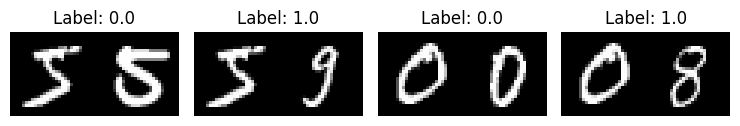

In [ ]:
visualize(pairs_train, labels_train, to_show=4, num_col=4)

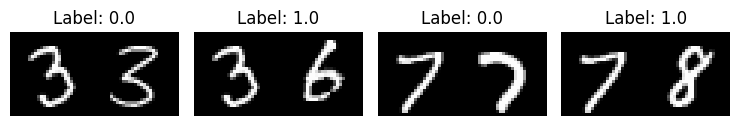

In [ ]:
visualize(pairs_val, labels_val, to_show=4, num_col=4)

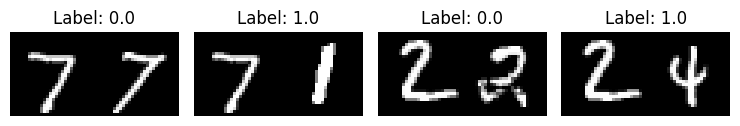

In [ ]:
visualize(pairs_test, labels_test, to_show=4, num_col=4)

# Define the model

* two inputs layers
* two networks (siamese network)
* lambda layer for compute euclidean distance
* final dense layer to merge outputs
* constrative loss

In [ ]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon())) # avoid zero division

In [ ]:
def loss(margin=1):
  def constrative_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )
  return constrative_loss

In [ ]:
input = layers.Input((28,28,1))
# baseline network
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5,5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(16, (5,5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)
plot_model(embedding_network, to_file='model_embedding.png', show_shapes=True, show_layer_names=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 10)                   5318      ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['model_2[0][0]',       

In [ ]:
input_1 = layers.Input((28,28,1))
input_2 = layers.Input((28,28,1))

# siamese network
# share weights between sisters
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()
plot_model(siamese, to_file='siamese_plot.png', show_shapes=True, show_layer_names=True)

# train the model

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size = batch_size,
    epochs = epochs,
)

NameError: ignored

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
  plt.plot(history[metric])
  if has_valid:
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel("epoch")
  plt.show()

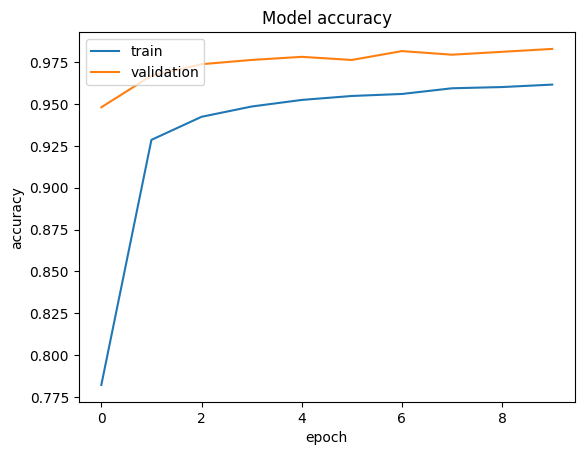

In [ ]:
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

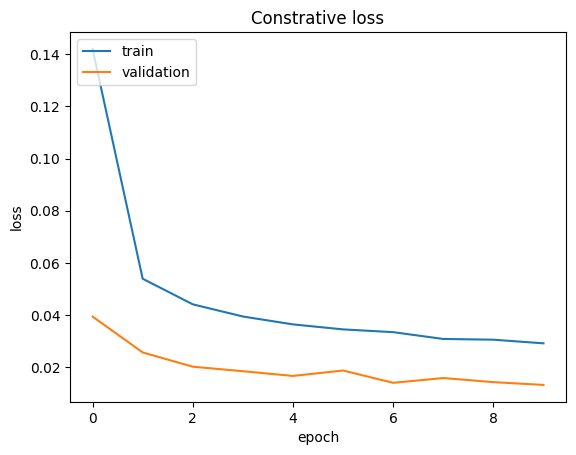

In [ ]:
plt_metric(history=history.history, metric="loss", title="Contrastive loss")

# evaluate the model

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc", results)

625/625 [==============================] - 3s 3ms/step - loss: 0.0138 - accuracy: 0.9826
test loss, test acc [0.013753842562437057, 0.9826499819755554]


# visualize the predictions

625/625 [==============================] - 2s 3ms/step


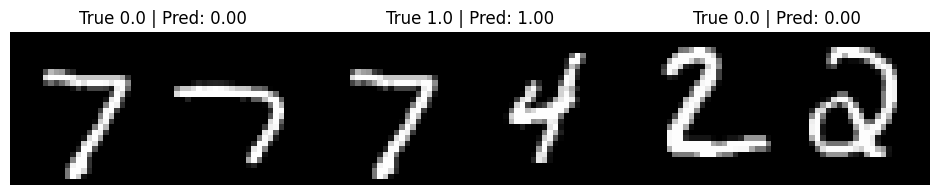

In [ ]:
predictions =  siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)